In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("image", cmap="gray")

In [3]:
from PIL import Image, ImageFont, ImageDraw
from scipy.ndimage import measurements, filters
import scipy.ndimage as ndi
import glob, re
from itertools import islice
import os, os.path

In [4]:
fontdir = "/usr/share/fonts/truetype/"
font_list = (glob.glob(fontdir+"liberation/*.ttf") +
         glob.glob(fontdir+"freefont/*.ttf") +
         glob.glob(fontdir+"dejavu/*.ttf"))
print(len(font_list))
print(font_list[:5])
sample_font = "/usr/share/fonts/truetype/freetype/FreeMonoBold.ttf"

34
['/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf']


In [5]:
def crop(image:np.ndarray, pad=1):
    [[r,c]] = measurements.find_objects(array(image==0,'i'))
    r0 = r.start
    r1 = r.stop
    c0 = c.start
    c1 = c.stop
    image = image[r0-pad:r1+pad,c0-pad:c1+pad]
    return image

In [6]:
def padq(image, q=16):
    h, w = image.shape
    hp = q-h%q if h%q>0 else 0
    wp = q-w%q if w%q>0 else 0
    return ndi.affine_transform(image, eye(2), output_shape=(h+hp, w+wp), mode="constant")

padq(ones((7, 7)), q=10).shape

(10, 10)

In [7]:
font_cache = {}

def load_font(fontname, size):
    pair = f"{fontname}::{size}"
    if pair not in font_cache:
        font_cache[pair] = ImageFont.truetype(fontname, size=size)
    return font_cache[pair]

In [8]:
from scipy import mgrid

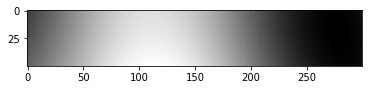

In [9]:
def mkbackground(shape, ncomponents=3, scales=(100.0, 5000.0)):
    h, w = shape
    ys, xs = mgrid[range(h), range(w)]
    result = zeros((h, w))
    for i in range(ncomponents):
        alpha = random.uniform(0, 2*pi)
        ly, lx = cos(alpha), sin(alpha)
        freq = exp(random.uniform(log(scales[0]), log(scales[1])))
        phase = random.uniform(0, 2*pi)
        amplitude = random.uniform(0, 1)
        result += sin((ly*ys+lx*xs)*2*pi/freq+phase)
    result -= amin(result)
    result /= amax(result)
    return result

imshow(mkbackground((50, 300)))

In [10]:
def normalize(a, range=(0, 1)):
    lo, hi = amin(a), amax(a)
    return (a-lo) / (hi-lo) * (range[1]-range[0]) + range[0] 

In [11]:
def mknoise(shape):
    nsigma = random.uniform(0.05, 2.0)
    noise = clip(random.normal(size=shape), -2, 2)
    noise = filters.gaussian_filter(noise, nsigma)
    return normalize(noise, range=(-1, 1))

In [12]:
def bounded_gaussian_noise(shape, sigma, maxdelta):
    n, m = shape
    deltas = pylab.rand(2, n, m)
    deltas = ndi.gaussian_filter(deltas, (0, sigma, sigma))
    deltas -= np.amin(deltas)
    deltas /= np.amax(deltas)
    deltas = (2*deltas-1) * maxdelta
    return deltas

def distort_with_noise(image, deltas, order=1):
    assert deltas.shape[0] == 2
    assert image.shape == deltas.shape[1:], (image.shape, deltas.shape)
    n, m = image.shape
    xy = np.transpose(np.array(np.meshgrid(
        range(n), range(m))), axes=[0, 2, 1])
    deltas += xy
    return ndi.map_coordinates(image, deltas, order=order, mode="constant")

def random_distort_word(image, level=1.0):
    sigma = exp(random.uniform(log(5.0), log(200.0)))
    maxdelta = level*random.uniform(0.2, 4.0)
    deltas = bounded_gaussian_noise(image.shape, sigma, maxdelta)
    return distort_with_noise(image, deltas)

(50, 161)


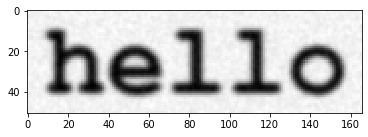

In [13]:
def gentextimage(text: str, pad:int=10, fontname=sample_font, size:int=48, maxpad=100):
    if isinstance(fontname, str): fontname = [fontname]
    if isinstance(size, int): size = [size]
    font = load_font(random.choice(fontname), random.choice(size))
    image = Image.new("L", (6000, 200))
    draw = ImageDraw.Draw(image)
    draw.rectangle((0, 0, 6000, 6000), fill="white")
    draw.text((20, 20), text, fill="black", font=font)
    image = asarray(image, "f")
    image = image / amax(image)
    image = crop(image, pad=10)
    return image

def random_padding(image, maxpad=30):
    h, w = image.shape
    p0, p1, q0, q1 = [random.randint(0, maxpad) for _ in range(4)]
    result = amax(image)*ones((h+p0+p1, w+q0+q1), dtype=image.dtype)
    result[p0:p0+h, q0:q0+w] = image
    return result

def sigmoid(x):
    return 1.0 / (1.0 + exp(-x))
def sigmoid5(x):
    return sigmoid(x-0.5)

def genline(text: str, pad:int=10, fontname=sample_font, size:int=48,
            bg=0.0,
            noiselevel=0.5,
            distort=0.0,
            maxpad=0):
    image = normalize(gentextimage(text=text, pad=pad, fontname=fontname, size=size))
    #image = sigmoid5(image + random.normal(size=image.shape)*0.3)
    sigma = random.uniform(0.05, 2.0)
    image = normalize(filters.gaussian_filter(image, sigma))
    if maxpad>0:
        image = random_padding(image, maxpad=maxpad)
    if noiselevel>0:
        noiselevel = noiselevel*random.uniform(0.05, 0.4)
        noise = mknoise(image.shape)
        image = normalize(image + noiselevel * noise)
    if bg>0:
        bg = bg * random.uniform(0.05, 0.4)
        image = normalize(image + bg * mkbackground(image.shape))
    image = 1-image
    if distort>0:
        image = normalize(random_distort_word(image))
    return image

figsize(6, 6)
imshow(1-genline("hello", size=range(48,52)))
print(genline("hello").shape)

In [14]:
from webdataset import writer
import pickle

def write_dataset(fname:str, data, n=50000):
    with open(fname, "wb") as stream:
        out = writer.TarWriter(stream)
        count = 0
        for i, (image, text) in enumerate(data):
            if count >= n: break
            if count%100==0: print(count, end=" ", file=sys.stderr, flush=True)
            out.write(dict(__key__=str(i), ppm=image, txt=text))
            count += 1
        out.close()
    print(file=sys.stderr, flush=True)
    print(f"# wrote {count} samples to {fname}")

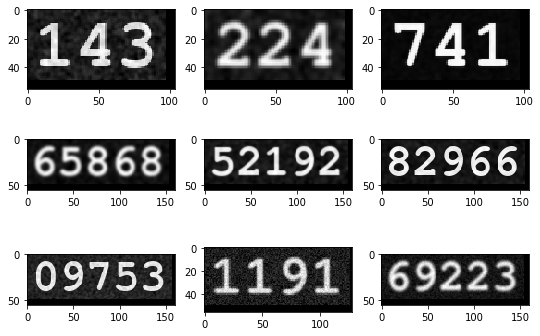

In [15]:
def gendigits(n:int=10, l0=3, l1=6, fontname=sample_font, size=48):
    result = []
    while True:
        k = random.randint(l0, l1) if l1>l0 else l0
        d = random.randint(1000000000, 1999999999)
        d = str(d)[-k:]
        image = genline(d, fontname=fontname, size=size)
        assert image.shape[0] >= 48 and image.shape[0] <= 55, image.shape
        #print(amin(image), amax(image))
        image = array(image*255.0, 'uint8')
        image = padq(image, q=8)
        yield image, d
        
figsize(9, 6)
data = list(islice(gendigits(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [16]:
import os, os.path
if not os.path.exists("data/digits-training.tar"):
    os.system("mkdir -p data")
    write_dataset("data/digits-training.tar", gendigits(), 50000)
    write_dataset("data/digits-test.tar", gendigits(), 10000)

In [17]:
!ls /usr/share/fonts/truetype/*.ttf | grep -i mono

In [18]:
dictionary = [l.strip() for l in open("/usr/share/dict/words", "r").readlines()]
pre_specials = """'"/-"""
post_specials = """'",.?!/-"""

def choose(a):
    return a[random.randint(0, len(a)-1)]
def basic_word():
    word = choose(dictionary)
    word = re.sub(r"""[^A-Za-z]""", "", word)
    return word
def extended_word():
    result = ""
    if random.uniform()<0.05: 
        result += choose(pre_specials)
    result += choose(dictionary)
    if random.uniform()<0.1:
        result += choose(post_specials)
    elif random.uniform()<0.01:
        result += "'s"
    elif random.uniform()<0.03:
        result += "/" + choose(dictionary)
    return result

print("basic:", " ".join([basic_word() for i in range(10)]))
print("extended:", " ".join([extended_word() for i in range(10)]))

basic: capitalistically Asiaticization dolichotmema helicoidal superbenefit satient ambrosially heartweed diobely flusterment
extended: salutiferous cockshead Stylidiaceae proarctic unstiffened inconsultable unregenerate unillustrious? semimonastic sahme


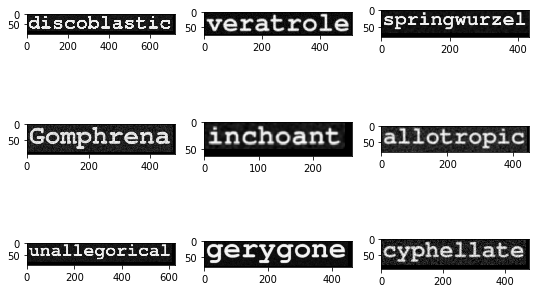

In [19]:
def genwords_simple(pad=10, extended=False, fonts=[sample_font]):
    while True:
        word = extended_word() if extended else basic_word()
        font = random.choice(fonts)
        size = random.randint(50, 100)
        image = genline(word, fontname=font, size=size)
        image = padq(image, q=16)
        yield image, word

figsize(9, 6)
data = list(islice(genwords_simple(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [20]:
if not os.path.exists("data/words-simple-training.tar"):
    write_dataset("data/words-simple-training.tar", genwords_simple(), 50000)
    write_dataset("data/words-simple-test.tar", genwords_simple(), 10000)

In [21]:
def genwords_hard(fonts=font_list):
    while True:
        word = extended_word()
        font = random.choice(fonts)
        size = random.randint(50, 100)
        try:
            image = genline(word, fontname=font, size=size, 
                            bg=1.0, noiselevel=1.0, distort=1.0, maxpad=30)
        except Exception as exn:
            print(exn)
            time.sleep(1.0)
            continue
        image = padq(image, q=16)
        yield image, word

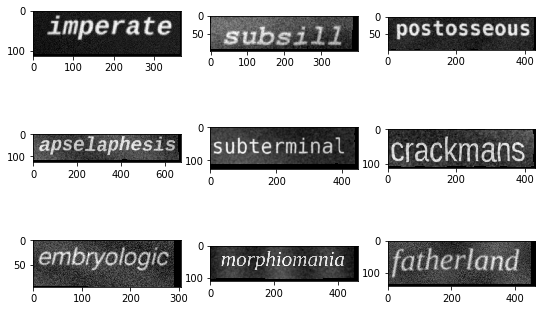

In [22]:
figsize(9, 6)
data = list(islice(genwords_hard(), 0, 10))
for i in range(9):
    subplot(3, 3, i+1); imshow(data[i][0])

In [23]:
if not os.path.exists("data/words-hard-training.tar"):
    write_dataset("data/words-hard-training.tar", genwords_hard(), 100000)
if not os.path.exists("data/words-hard-test.tar"):
    write_dataset("data/words-hard-test.tar", genwords_hard(), 10000)